In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import matplotlib as mpl
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
from scipy.stats import binned_statistic
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [7,5]
%run Fraunhofer.py
%run ErrMask.py

screen [m] - FT [1/m] - sky [theta] - FT [1/theta] 

bin radially 

In [ ]:
# sigma & fwhm in real space [radians]
# fourier space: [1/radians]
def fwhm_to_sigma(fwhm):
  sigma = fwhm/(np.log(2)*8)
  return(sigma)
def b_lm(l, sigma):
  #l = screen['kap']*np.pi*2
  #blm = np.sqrt((2*k_vec+1)/(4*np.pi)) * np.exp(-k_vec*(k_vec+1)*sigma**2/2)
  blm = np.exp(-l*(l)*sigma**2/2)
  return(blm)


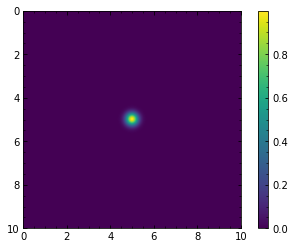

In [ ]:
A = 1
screen0 = {}
screen0['N'] = 1024
screen0['D'] = 10
Initialize(screen0)
center = (screen0['D']/2, screen0['D']/2)
MultByGaussian(screen0, center, 0.2)
InCircle(screen0, center, 2.0)
ScreenFFT(screen0)

lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 1.0
thetamax = 2*np.pi/180. # 2 degrees in radians
#theta_vec = np.linspace(-thetamax,thetamax,3000) 
##II0 = Project_I_on_thetagrid(theta_vec,screen0,lam) 

plt.imshow(screen0['E'],extent=(0, screen0['D'], screen0['D'], 0))
plt.colorbar()

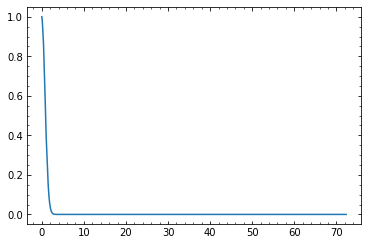

In [ ]:

bin_edges = np.arange(0,screen0['kap'].max(),0.08)
k_r = screen0['kap'].flatten()
fft_m = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(screen0['E'])))).flatten()
bin_mean, bin_edge, bin_num = binned_statistic(k_r, fft_m, statistic='mean', bins=bin_edges)
plt.plot(bin_edges[0:-1],bin_mean/bin_mean.max())
#plt.xlim(0,2)

# bin blm???
# blm_k_edges = np.arange(0,screen0['kap'].max(),0.05)
# blm = b_lm(screen0, 1.0)
# blm_bin = blm.flatten()
# blm_mean, blm_edge, blm_num = binned_statistic(k_r, blm_bin, statistic='mean', bins=blm_k_edges)


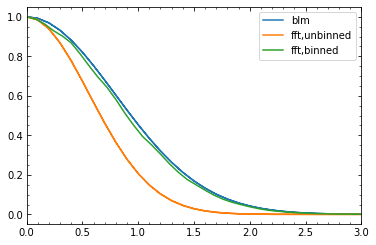

In [ ]:
blm = b_lm(screen0, 0.2)
#plt.plot(blm_k_edges[0:-1], blm_mean, label='b_lm')
plt.plot(screen0['kap'][512], blm[512], label='blm')
plt.plot(screen0['kap'][512], screen0['I'][512]/screen0['I'][512].max(),label='fft,unbinned') # unbinned
plt.plot(bin_edges[0:-1], bin_mean/bin_mean.max(),label='fft,binned') # binned
plt.xlim(0,3)
plt.legend()

In [ ]:
screen0['kap'].max()

289.6309375740099

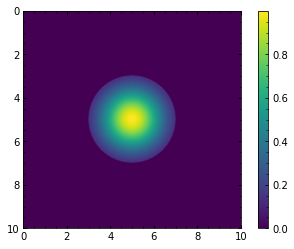

In [ ]:
# screen [m] - FT [1/m] - sky [theta] - FT [1/theta]  no interpolation
A = 1
screen0 = {}
screen0['N'] = 1024
screen0['D'] = 10
Initialize(screen0)
center = (screen0['D']/2, screen0['D']/2)
sigma = 1.0
MultByGaussian(screen0, center, sigma)
InCircle(screen0, center, 2.0)
ScreenFFT(screen0)

lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
#thetamaxdeg = 1.0
#thetamax = 2*np.pi/180. # 2 degrees in radians
# theta_vec = np.linspace(-thetamax,thetamax,2048) 
# II0 = Project_I_on_thetagrid(theta_vec,screen0,lam) #interpolation

#convert k space (1/m) directly to sky (rad): k = k_photon * sin(theta)
# --> theta = np.arcsin(k/k_photon)
theta = np.arcsin(screen0['kap']/kphot) #in rad


plt.imshow(screen0['E'],extent=(0, screen0['D'], screen0['D'], 0))
plt.colorbar()

In [ ]:
theta = np.arcsin(screen0['kap']/kphot) #in rad
dk = 1/theta.max() #in second FT space (1/rad)
ell = dk*np.fft.fftfreq(theta.shape[0])*theta.shape[0] * 2*np.pi
#print(np.abs(ell).min())
#plt.

0.0


In [ ]:
N = screen0['N']
ones = np.ones(N)
pix_size = 0.5 #arcmin
inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.) # pix_size in radians
kY = np.transpose(kX)
K = np.sqrt(kX**2. + kY**2.)
ell_scale_factor = 2. * np.pi 
ell2d = K * ell_scale_factor
print(ell2d[512])
plt.imshow(ell2d,vmax=3000)
plt.colorbar()

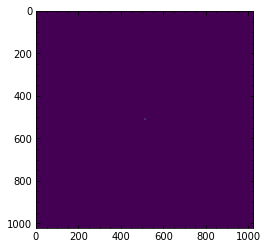

In [ ]:
I_sky = (np.fft.fftshift(np.fft.fft2(np.fft.fftshift(screen0['E']))))**2 # in rad space (k space) (complex intensity)
plt.imshow(np.abs(I_sky))


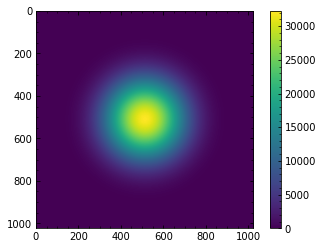

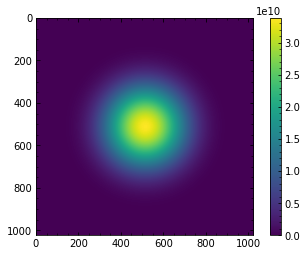

In [ ]:
fft_iI = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(I_sky))) # ifft of sky intensity 
fft_I = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_sky)))   # fft of sky intensity (1/rad)
plt.imshow(np.abs(fft_iI))
plt.colorbar()
plt.show()
plt.imshow(np.abs(fft_I))
plt.colorbar()

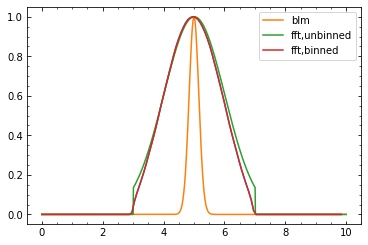

In [ ]:
# test the analytic solution with sigma measured in sky (rad space), keep track of units. --> calculate the sigma in k space 
# from sigma in real space. Then this sigma in k space is the input to our analytic solution. 
# then compare the second FT with the analytic solution.

bin_edges = np.arange(0,screen0['X'].max(),0.08) 
k_r = screen0['X'].flatten() 
fft_m = np.abs(fft_I).flatten()
bin_mean, bin_edge, bin_num = binned_statistic(k_r, fft_m, statistic='mean', bins=bin_edges)
plt.plot(bin_edges[0:-1],bin_mean/bin_mean.max())
#plt.xlim(0,2)

#l = screen0['kap']*np.pi*2
blm = np.exp(-l*(l)*sigma**2/2)
#plt.plot(blm_k_edges[0:-1], blm_mean, label='b_lm')
plt.plot(screen0['X'][512], blm[512], label='blm')
plt.plot(screen0['X'][512], np.abs(fft_I[512])/np.abs(fft_I)[512].max(),label='fft,unbinned') # unbinned
plt.plot(bin_edges[0:-1], bin_mean/bin_mean.max(),label='fft,binned') # binned
#plt.xlim(4.7,5.3)
plt.legend()

0.009765625

# 12/16 test

In [ ]:
def sigma_interp(theta_max, k0_max, sigma):
  lam = 0.002 #mm wavelength
  kphot = 2*np.pi/lam
  theta0_max = np.arcsin(k0_max/kphot)
  sigma_k = (1/sigma) * np.sin(theta_max/theta0_max) # in k
  sigma_theta = np.arcsin(sigma_k/kphot) /(2*np.pi) # in rad
  #sigma_theta = np.sqrt( (1/sigma**2) + np.log(np.sin(theta_max/theta0_max))/k**2 )
  return(sigma_theta)
def b_lm(l, sigma):
  #l = screen['kap']*np.pi*2
  blm = np.exp(-l*(l+1)*sigma**2/4)
  return(blm)
def sigma_calc(r,sigma):
  gaussian = bin_mean.max()*np.exp(-r**2/(2*sigma**2))
  return(gaussian)

#sigma_interp(thetamax, screen0['kap'].max(), 1.0)

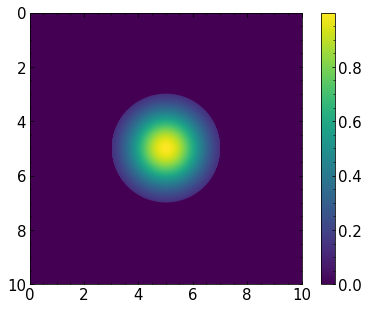

In [ ]:
# interpolation

screen0 = {}
screen0['N'] = 8192
screen0['D'] = 10
Initialize(screen0)
center = (screen0['D']/2, screen0['D']/2)
MultByGaussian(screen0, center, 1.0)
InCircle(screen0, center, 2.0)
ScreenFFT(screen0)

lam = 0.002 #mm wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 3.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,1024) 
II0 = Project_I_on_thetagrid(theta_vec,screen0,lam) 

plt.imshow(screen0['E'],extent=(0, screen0['D'], screen0['D'], 0))
plt.colorbar()

(4030.0, 4160.0)

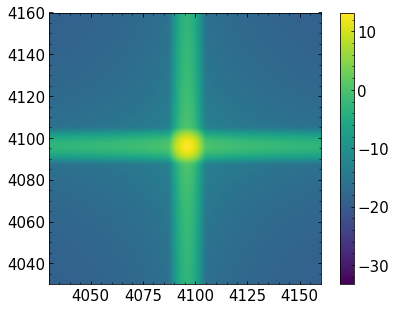

In [ ]:
plt.imshow(np.log10(screen0['I']), interpolation=None)
plt.colorbar()
plt.xlim(4030,4160)
plt.ylim(4030,4160)

(960.0, 1088.0)

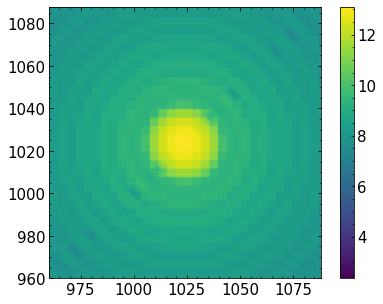

In [ ]:
plt.imshow(np.log10(II0))
plt.colorbar()
#plt.xlim(460,564)
#plt.ylim(460,564)
plt.xlim(960,1088)
plt.ylim(960,1088)

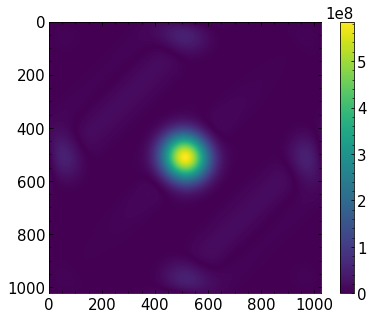

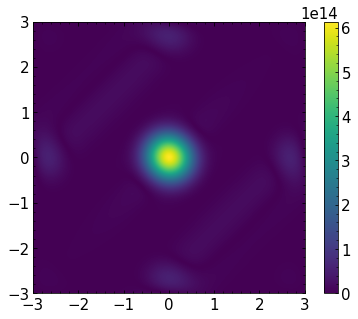

In [ ]:
# FT to 1/rad (l space)
# n = theta_vec.shape[0]
# dk = 1/theta_vec.max() # dk in 1/rad space
# k_vec = dk*np.fft.fftfreq(n)*n * 2*np.pi

fft_iI = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(II0))) # ifft of sky intensity 
fft_I = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))   # fft of sky intensity (1/rad) 
blm_numerical = np.abs(fft_I)**2 #numerically calculated beam in [1/rad] k space
plt.imshow(np.abs(fft_iI))
plt.colorbar()
plt.show()
plt.imshow(np.abs(fft_I),extent=(-thetamaxdeg, thetamaxdeg,-thetamaxdeg, thetamaxdeg))
plt.colorbar()

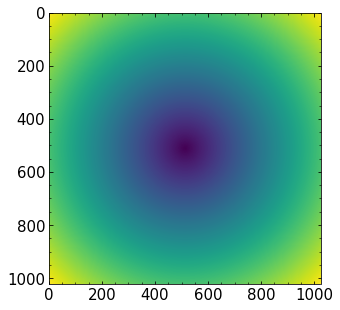

In [ ]:
# calculate ell
n = theta_vec.shape[0]
dk = 1/theta_vec.max() # dk in 1/rad space
k_vec = dk*np.fft.fftshift(np.fft.fftfreq(n))*n
(k_x, k_y) = np.meshgrid(k_vec,k_vec) # 1/rad 
k_r = np.sqrt(k_x**2 + k_y**2)
l = k_r * 2 * np.pi
plt.imshow(l)

[0.0002427]


(0.0, 0.005)

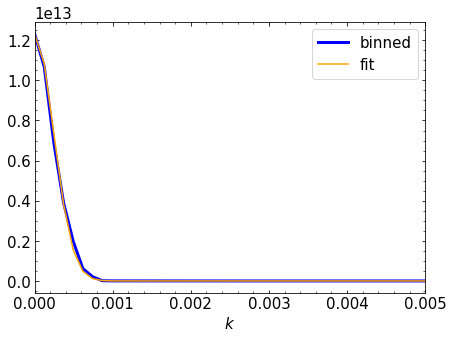

In [ ]:
# fit sigma in sky (rad)
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt(thetax**2 + thetay**2)
#bin_edges = np.arange(0,theta_r.max(),2e-4)
bin_edges = np.linspace(0,theta_r.max(),600)
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_mean, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bin_edges)
(fit, err) = opt.curve_fit(sigma_calc, bin_edges[0:-1], bin_mean, p0=1e-4, absolute_sigma=True)
print(fit)
plt.plot(bin_edges[0:-1],bin_mean, lw=3, color='blue',label='binned')
plt.xlabel(r'$k$')
plt.plot(bin_edges, sigma_calc(bin_edges, fit[0]), lw=1.5, color='orange',label='fit')
plt.legend();
plt.xlim(0,0.005)


In [ ]:
def b_lm(l, sigma):
  blm = np.exp(-l*(l+1)*sigma**2/2)
  return(blm)

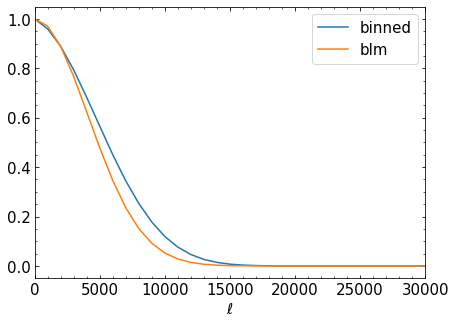

In [ ]:
# average radially 
bin_edges = np.arange(0,l.max(),1000)
l_flatten = l.flatten()
beam_numerical_flatten = blm_numerical.flatten()
bin_mean, bin_edge, bin_num = binned_statistic(l_flatten, beam_numerical_flatten, statistic='mean', bins=bin_edges)

l_vec = bin_edges[0:-1].copy()

plt.plot(l_vec,bin_mean/bin_mean.max(),label='binned')
plt.xlabel(r'$\ell$')
blm = b_lm(l_vec, fit[0])
#plt.plot(l_vec, b_lm(l_vec, fit[0]), label='fit')
plt.plot(l_vec, blm,label='blm')
plt.xlim(0,3e4)
plt.legend();

In [ ]:
8192*2

16384

# 01/31/2023 
BEAM_test_new.py to generate power spectrum with different screenD

In [12]:
a=np.array([1,2,3])
b=np.array([4,5,6])
zip(a,b)
import csv
with open('text.csv', 'w') as f:
   writer = csv.writer(f, delimiter='\t')
   writer.writerows(zip(a,b))

In [13]:
(x,y) = np.loadtxt('text.csv',unpack=True)

In [14]:
y

array([4., 5., 6.])